<a href="https://colab.research.google.com/github/mnjkhtri/brain-tumor-detection-and-localization/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **EDA and Preprocessing**

In [84]:
import pandas as pd
import numpy as np
import glob
import os
import cv2
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

In [28]:
DATA_PATH = "/content/drive/MyDrive/ColabNotebooks/kaggle_3m/"

In [29]:
data_map = []
for sub_dir_path in glob.glob(DATA_PATH+"*"):
    if os.path.isdir(sub_dir_path):
        dirname = sub_dir_path.split("/")[-1]
        for filename in os.listdir(sub_dir_path):
            image_path = sub_dir_path + "/" + filename
            data_map.extend([dirname, image_path])
    else:
        print("This is not a dir:", sub_dir_path)


df = pd.DataFrame(
    {"dirname" : data_map[::2], "path" : data_map[1::2]}
)

df.head()

This is not a dir: /content/drive/MyDrive/ColabNotebooks/kaggle_3m/README.md
This is not a dir: /content/drive/MyDrive/ColabNotebooks/kaggle_3m/data.csv


,dirname,path
0,TCGA_DU_7306_19930512,/content/drive/MyDrive/ColabNotebooks/kaggle_3...
1,TCGA_DU_7306_19930512,/content/drive/MyDrive/ColabNotebooks/kaggle_3...
2,TCGA_DU_7306_19930512,/content/drive/MyDrive/ColabNotebooks/kaggle_3...
3,TCGA_DU_7306_19930512,/content/drive/MyDrive/ColabNotebooks/kaggle_3...
4,TCGA_DU_7306_19930512,/content/drive/MyDrive/ColabNotebooks/kaggle_3...


In [56]:
df_imgs = df[~df['path'].str.contains("mask")]
df_masks = df[df['path'].str.contains("mask")]

BASE_LEN = len(df_imgs['path'].values[0]) - len('xx.tif')
END_IMG_LEN = -len('.tif')
END_MASK_LEN = -len('xmask.tif')

In [57]:
df_imgs['path'].values[0][BASE_LEN:END_IMG_LEN], df_masks['path'].values[0][BASE_LEN:END_MASK_LEN]

('14', '16')

In [62]:
imgs = sorted(df_imgs["path"].values, key=lambda x : int(x[BASE_LEN:END_IMG_LEN]))
masks = sorted(df_masks["path"].values, key=lambda x : int(x[BASE_LEN:END_MASK_LEN]))

In [63]:
# Sorting check
idx = np.random.randint(0, len(imgs)-1)
print("Path to the Image:", imgs[idx], "\nPath to the Mask:", masks[idx])

Path to the Image: /content/drive/MyDrive/ColabNotebooks/kaggle_3m/TCGA_HT_8113_19930809/TCGA_HT_8113_19930809_19.tif 
Path to the Mask: /content/drive/MyDrive/ColabNotebooks/kaggle_3m/TCGA_HT_8113_19930809/TCGA_HT_8113_19930809_19_mask.tif


In [67]:
df = pd.DataFrame(
    {"patient": df_imgs.dirname.values, "image_path": imgs, "mask_path": masks}
)

def positiv_negativ_diagnosis(mask_path):
    value = np.max(cv2.imread(mask_path))
    if value > 0 : return 1
    else: return 0

df["diagnosis"] = df["mask_path"].apply(lambda m: positiv_negativ_diagnosis(m))

In [68]:
df['diagnosis'].sum()

1373

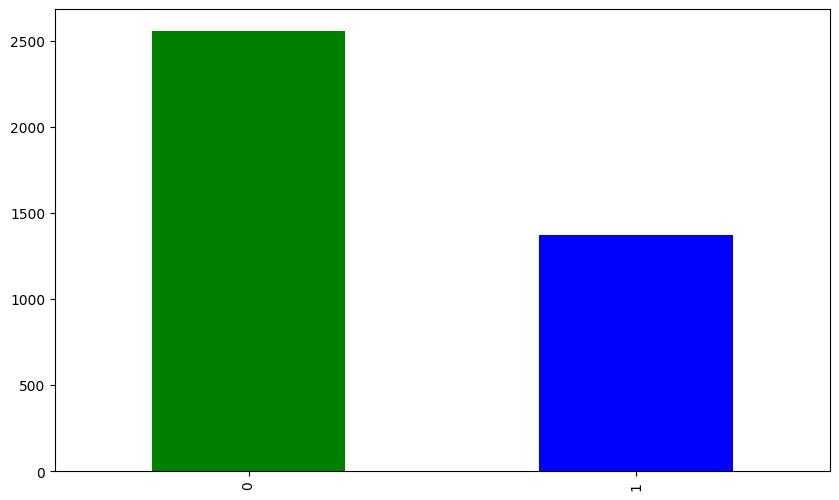

In [69]:
ax = df.diagnosis.value_counts().plot(
    kind='bar',
    stacked=True,
    figsize=(10, 6),
    color=["green", "blue"]
)

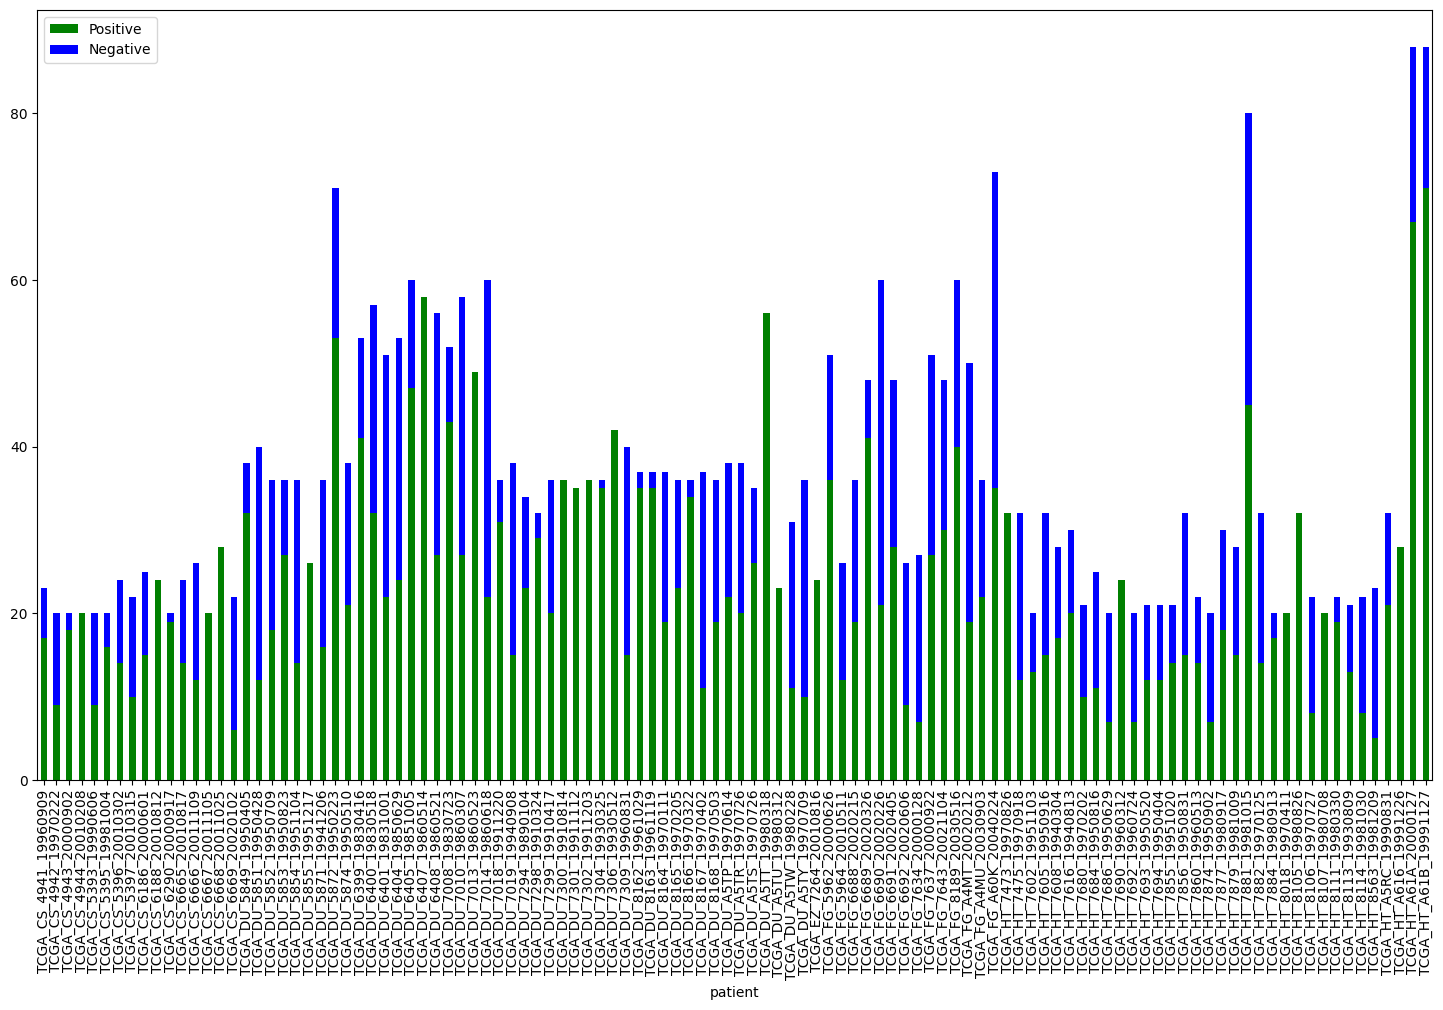

In [70]:
patients_by_diagnosis = df.groupby(['patient', 'diagnosis'])['diagnosis'].size().unstack().fillna(0)
patients_by_diagnosis.columns = ["Positive", "Negative"]

ax = patients_by_diagnosis.plot(
    kind='bar',
    stacked=True,
    figsize=(18, 10),
    color=["green", "blue"],
)

In [73]:
IMG_SIZE = 512

sample_df = df[df["diagnosis"] == 1].sample(5).values
sample_imgs = []
for i, data in enumerate(sample_df):
    img = cv2.resize(cv2.imread(data[1]), (IMG_SIZE, IMG_SIZE))
    mask = cv2.resize(cv2.imread(data[2]), (IMG_SIZE, IMG_SIZE))
    sample_imgs.extend([img, mask])

In [82]:
sample_imgs_arr = np.hstack(np.array(sample_imgs[::2]))
sample_masks_arr = np.hstack(np.array(sample_imgs[1::2]))

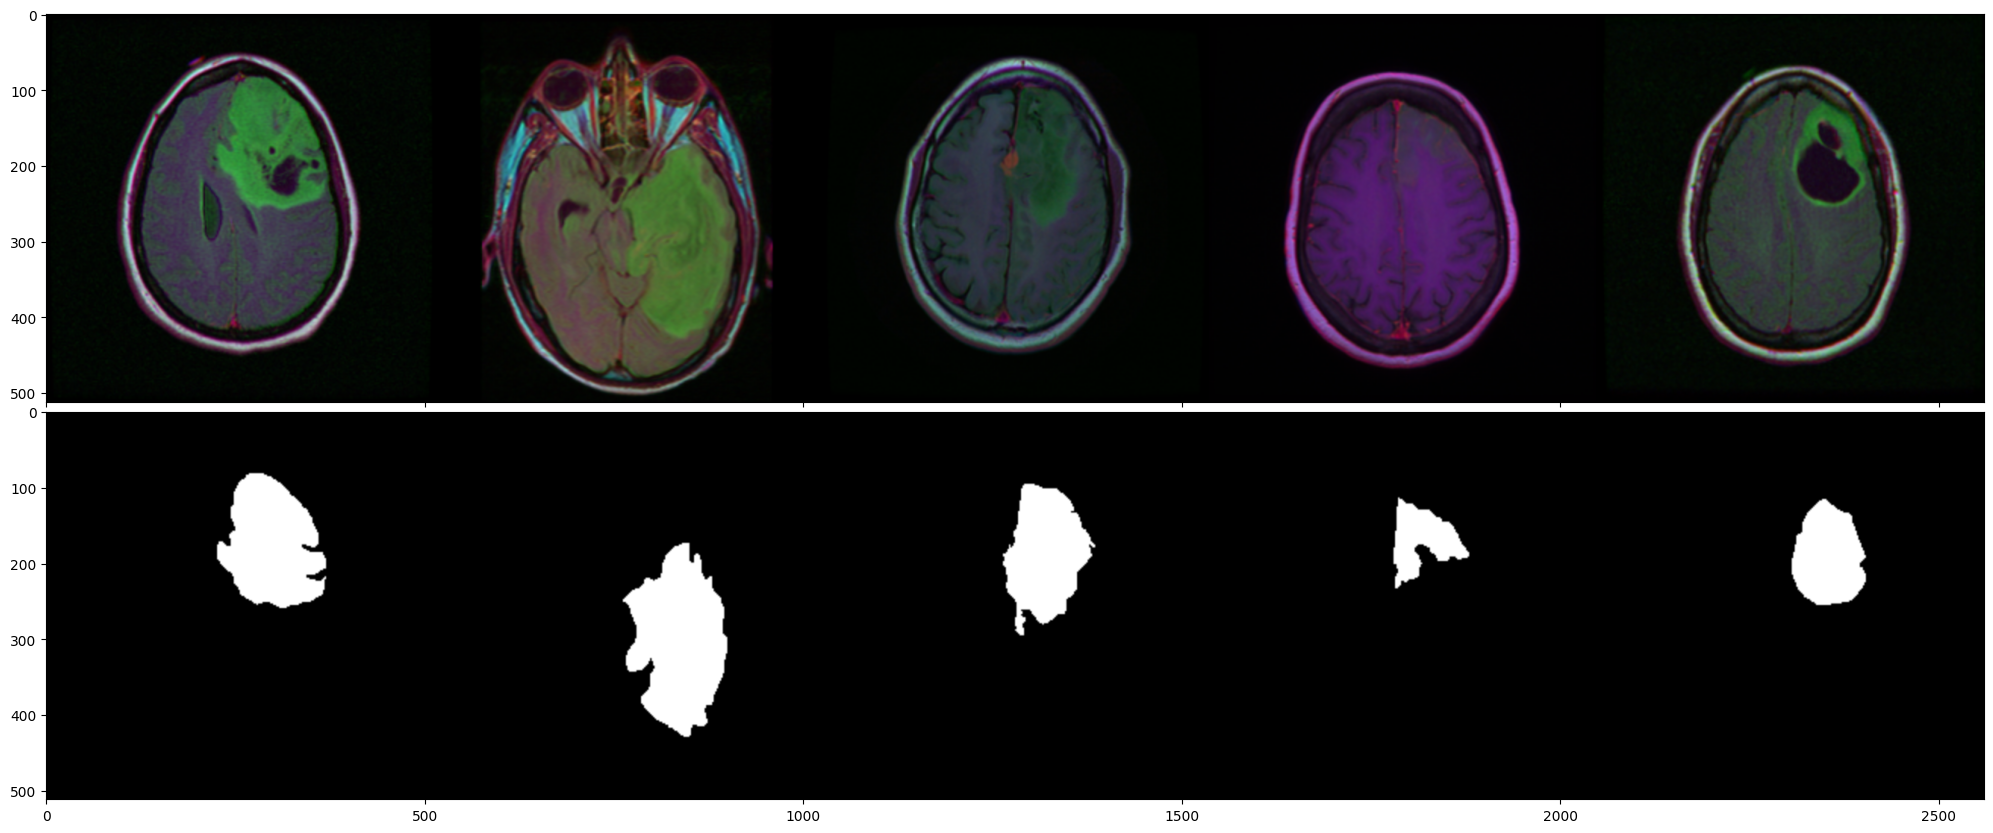

In [81]:
fig = plt.figure(figsize=(25., 25.))
grid = ImageGrid(fig, 111, nrows_ncols=(2, 1), axes_pad=0.1)

grid[0].imshow(sample_imgs_arr)
grid[1].imshow(sample_masks_arr)

# **Augmentation**

In [86]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import albumentations as A
from albumentations.pytorch import ToTensorV2

from sklearn.model_selection import train_test_split

In [87]:
class BrainMriDataset(Dataset):
    def __init__(self, df, transforms):

        self.df = df
        self.transforms = transforms

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image = cv2.imread(self.df.iloc[idx, 1])
        mask = cv2.imread(self.df.iloc[idx, 2], 0)

        augmented = self.transforms(image=image, mask=mask)

        image = augmented['image']
        mask = augmented['mask']

        return image, mask

In [90]:
PATCH_SIZE = 128#256


transforms = A.Compose([
    A.Resize(width = PATCH_SIZE, height = PATCH_SIZE, p=1.0),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.Transpose(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.01, scale_limit=0.05, rotate_limit=0, p=0.25),


    A.Normalize(p=1.0),
    ToTensorV2(),
])

strong_transforms = A.Compose([
    A.RandomResizedCrop(width = PATCH_SIZE, height = PATCH_SIZE, p=1.0),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.Transpose(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.01, scale_limit=0.05, rotate_limit=0, p=0.25),

    # Pixels
    A.RandomBrightnessContrast(p=0.5),
    A.RandomGamma(p=0.25),
    A.IAAEmboss(p=0.25),
    A.Blur(p=0.01, blur_limit = 3),

    # Affine
    A.OneOf([
        A.ElasticTransform(p=0.5, alpha=120, sigma=120 * 0.05, alpha_affine=120*0.03),
        A.GridDistortion(p=0.5),
        A.OpticalDistortion(p=1, distort_limit=2, shift_limit=0.5)
    ], p=0.8),


    A.Normalize(p=1.0),
    ToTensorV2(),
])

In [91]:
train_df, val_df = train_test_split(df, stratify=df.diagnosis, test_size=0.1)
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

# Split train_df into train_df and test_df
train_df, test_df = train_test_split(train_df, stratify=train_df.diagnosis, test_size=0.15)
train_df = train_df.reset_index(drop=True)

#train_df = train_df[:1000]
print(f"Train: {train_df.shape} \nVal: {val_df.shape} \nTest: {test_df.shape}")

Train: (3005, 4) 
Val: (393, 4) 
Test: (531, 4)


In [93]:
# train
train_dataset = BrainMriDataset(df=train_df, transforms=transforms)
train_dataloader = DataLoader(train_dataset, batch_size=26, num_workers=2, shuffle=True)

# val
val_dataset = BrainMriDataset(df=val_df, transforms=transforms)
val_dataloader = DataLoader(val_dataset, batch_size=26, num_workers=2, shuffle=True)

#test
test_dataset = BrainMriDataset(df=test_df, transforms=transforms)
test_dataloader = DataLoader(test_dataset, batch_size=26, num_workers=2, shuffle=True)

torch.Size([26, 3, 128, 128]) torch.Size([26, 128, 128])


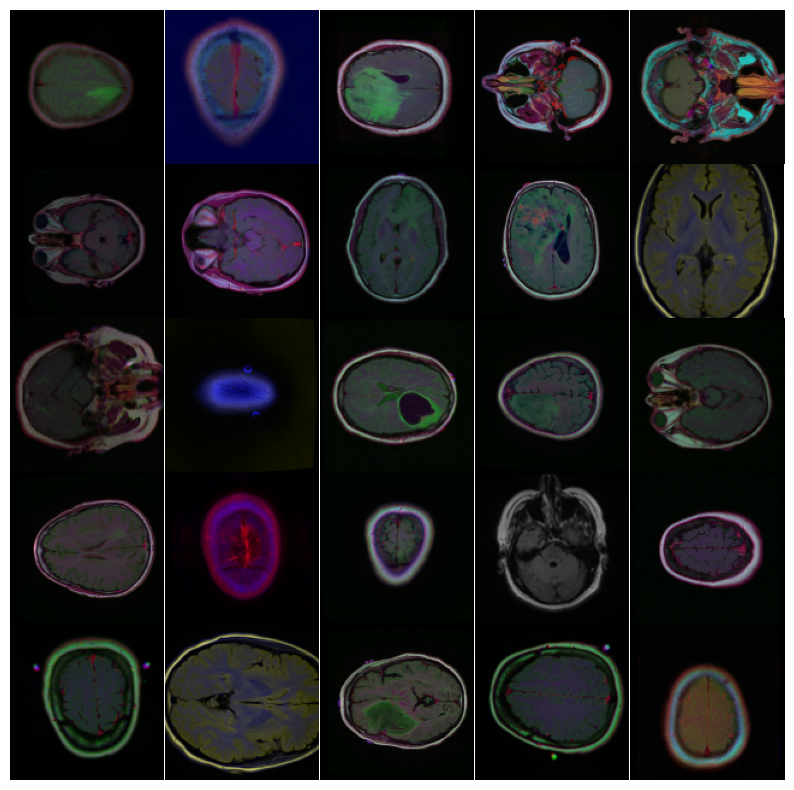

IndexError: ignored

<Figure size 1000x1000 with 0 Axes>

In [94]:
def show_aug(inputs, nrows=5, ncols=5, image=True):
    plt.figure(figsize=(10, 10))
    plt.subplots_adjust(wspace=0., hspace=0.)
    i_ = 0

    if len(inputs) > 25:
        inputs = inputs[:25]

    for idx in range(len(inputs)):

        # normalization
        if image is True:
            img = inputs[idx].numpy().transpose(1,2,0)
            mean = [0.485, 0.456, 0.406]
            std = [0.229, 0.224, 0.225]
            img = (img*std+mean).astype(np.float32)
        else:
            img = inputs[idx].numpy().astype(np.float32)
            img = img[0,:,:]

        #plot
        #print(img.max(), len(np.unique(img)))
        plt.subplot(nrows, ncols, i_+1)
        plt.imshow(img);
        plt.axis('off')

        i_ += 1

    return plt.show()


images, masks = next(iter(train_dataloader))
print(images.shape, masks.shape)

show_aug(images)
show_aug(masks, image=False)